In [1]:
import os
import sys
from hashlib import sha256
import random

In [2]:
import pandas as pd
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [3]:
from jose.helpers import file_functions
from lared.dataset.example import VideoExample, AudioExample, FullExample
from lared.data_loading.utils import get_video_caps, AudioFiles
from annotation.coco_reader import CocoReader
from lared_laughter.constants import raw_video_path, raw_audio_path, \
    processed_data_path, datasets_path, annot_exp_path as original_exp_path

In [4]:
VideoExample.init_caps(get_video_caps(raw_video_path))
VideoExample.init_camera_annotation(os.path.join(processed_data_path, 'elan_out/camera.txt'))
AudioExample.init_dataset(AudioFiles(raw_audio_path))

In [5]:
# load ELAN annotations
laughter_ann_path = os.path.join(processed_data_path, 'elan_out/laughter.txt')
# path for output images
annot_exp_path = os.path.join(os.environ['PROC_DATA_PATH'], 'lared_laughter', 'annotation_experiment_2')

laughter_ann = pd.read_csv(laughter_ann_path, sep='\t',names=['name','participant','ini','fin','dur','type'],header=None)
df_laughter_by_participant = laughter_ann.groupby('participant')

In [6]:
dfs_laughter = []
for i in df_laughter_by_participant.groups:
    dfs_laughter.append(df_laughter_by_participant.get_group(i))
participant_ids = df_laughter_by_participant.groups.keys()
participant_ids = [int(id) for id in participant_ids]

In [7]:
# total number of annotated laughter
sum([len(df) for df in dfs_laughter])

1838

# Apply episode threshold

In [8]:
dfs_laughter[0].tail(2)

,name,participant,ini,fin,dur,type
65,laughter1,1,6628.40,6629.84,1.44,laughter
66,laughter1,1,6630.84,6631.88,1.04,laughter


In [9]:
# join episodes/bouts that are closer than 1s in time
threshold = 1
num_deleted = 0
num_episodes = 0
for df in dfs_laughter:
    df.reset_index(inplace=True)
    to_delete = []
    for i, row in enumerate(df.iterrows()):
        num_episodes += 1
        if i == len(df)-1: 
            continue
        if (df.loc[i+1, 'ini'] - df.loc[i, 'fin']) < 1:
            df.loc[i+1, 'ini'] = df.loc[i, 'ini']
            to_delete.append(i)
    
    num_deleted += len(to_delete)
    df.drop(to_delete, inplace=True)
print(f'Joined / deleted: {num_deleted} / {num_episodes}')

/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a 

Joined / deleted: 28 / 1838


/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(to_delete, inplace=True)
/tmp/ipykernel_243/539490143.py:17: SettingWithCopyWarning: 
A value is trying to be set on a 

In [10]:
# add prev_fin and next_ini
for df in dfs_laughter:
    df.reset_index(inplace=True)
    prev_fin = []
    next_ini = []
    for i, row in enumerate(df.iterrows()):
        prev_fin.append(0 if i == 0 else df.loc[i-1, 'fin'])
        next_ini.append(1000000 if i == len(df)-1 else df.loc[i+1, 'ini'])
    df.insert(6, 'prev_fin', prev_fin)
    df.insert(7, 'next_ini', next_ini)

In [11]:
sum([len(df) for df in dfs_laughter])

1810

In [12]:
dfs_laughter[0].head(2)

,level_0,index,name,participant,ini,fin,prev_fin,next_ini,dur,type
0,0,0,laughter1,1,1028.28,1030.08,0.00,1049.98,1.80,laughter
1,1,1,laughter1,1,1049.98,1051.30,1030.08,1099.88,1.32,laughter


# Filter out segments of the interaction

In [13]:
# valid segments
# permisive
# [15:00 - 25:25]
# [27:00 - 40:50]
# [43:00 - 48:42]
# [49:00 - 1:30:35]
# [1:33:00 - 2:44:00]

# strict
# [16:30 - 25:25]
# [28:00 - 40:50]
# [43:00 - 48:42]
# [55:20 - 1:30:35]
# [1:33:00 - 2:44:00]

In [14]:
# checks if an example is within the valid parts of the interaction
# segments of the interaction where people are not in free-for-all were removed (made invalid)
# the fn returns false if the example is within those segments.
def is_valid(s):
    valid_segs = [
        [990, 1525],
        [1680, 2450],
        [2580, 2922],
        [3320, 5435],
        [5580, 9840]
    ]
    for seg in valid_segs:
        if s[0] >= seg[0] and s[1] < seg[1]:
            return True
    return False

def is_valid_row(row):
    return is_valid([row['ini'], row['fin']])

In [15]:
num_kept = 0
num_episodes = 0
for i, df in enumerate(dfs_laughter):
    m = df.apply(is_valid_row, axis=1)
    num_kept += np.sum(m)
    num_episodes += len(m)
    dfs_laughter[i] = df[m]
print(f'Kept: {num_kept} / {num_episodes}')

Kept: 1493 / 1810


# Laughter example: generation

generate the base set of laughter examples

In [16]:
random.seed(22)
np.random.seed(22)

In [17]:
# Pad and split examples
laughter_examples = dict()
camera_distrib = {0: 0, 1:0, 2:0, 3:0, 4:0}
for i, (pid, df_laughter) in tqdm(enumerate(zip(participant_ids, dfs_laughter))):
    for index,row in df_laughter.iterrows():
        ex = FullExample(
            pid= pid,
            ini_time= row['ini'],
            end_time= row['fin'])
        ex.random_pad(1.5, 3.5, min_ini=row['prev_fin'], max_end=row['next_ini'])
        ex.set_camera()
        exs = ex.split_by_camera()
        camera_distrib[len(exs)] += 1

        for example in exs:
            laughter_examples[example.get_hash()] = example

0it [00:00, ?it/s]

<BarContainer object of 5 artists>

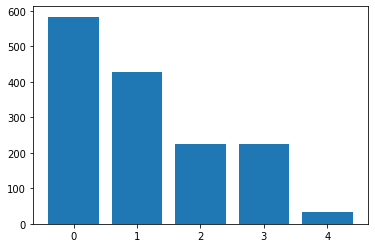

In [18]:
# distribution of num examples among subject IDs
plt.bar(camera_distrib.keys(), camera_distrib.values())

# Laughter examples: loading
load a previously generated set of examples

In [19]:
laughter_examples_df = pd.read_csv(os.path.join(annot_exp_path, 'laughter_examples', 'examples.csv'), index_col=0)
laughter_examples = {ex[1].hash: FullExample(**ex[1].to_dict()) for ex in laughter_examples_df.iterrows()}

# Get the distribution

In [20]:
pid_distrib = {pid: 0 for pid in participant_ids}
for ex in laughter_examples.values():
    pid_distrib[ex.pid] += 1

<BarContainer object of 33 artists>

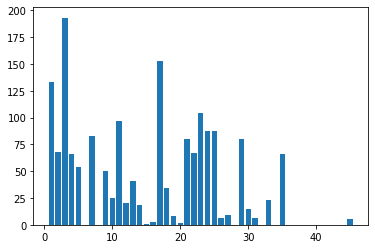

In [21]:
# distribution of num examples among subject IDs
plt.bar(pid_distrib.keys(), pid_distrib.values())

In [22]:
# write images for laughter examples
laughter_images_path = os.path.join(annot_exp_path, 'laughter_examples', 'images')
pilot_examples = random.sample(list(laughter_examples.values()), 1000)
for ex in tqdm(pilot_examples):
    ex.write_full_first_image(laughter_images_path)
(len(pilot_examples), len(laughter_examples))

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 1684)

In [26]:
audio_path = os.path.join(annot_exp_path, 'laughter_examples_comp', 'audio')
video_path = os.path.join(annot_exp_path, 'laughter_examples_comp', 'video')
av_path = os.path.join(annot_exp_path, 'laughter_examples_comp', 'av')
aiv_path = os.path.join(annot_exp_path, 'laughter_examples_comp', 'aiv')
if not os.path.exists(audio_path): os.makedirs(audio_path)
if not os.path.exists(video_path): os.makedirs(video_path)
if not os.path.exists(av_path): os.makedirs(av_path)
if not os.path.exists(aiv_path): os.makedirs(aiv_path)

In [24]:
coco_reader = CocoReader(os.path.join(annot_exp_path, 'laughter_examples', 'cvat.json'))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/Jose/gdrive/data/lared_laughter/annotation_experiment_2/laughter_examples/cvat.json'

In [24]:
# write back the bbs
for hash, ex in tqdm(laughter_examples.items()):
    if hash not in coco_reader:
        continue
    ex.rect = coco_reader[hash]
    if not ex.rect:
        continue
    ex.write_audio(audio_path, padded=True)
    # ex.write_audio_video(audio_path, './audio.png', aiv_path)
    ex.write_video(video_path, padded=True)
    ex.write_audiovisual(video_path, audio_path, av_path)

  0%|          | 0/1684 [00:00<?, ?it/s]

TypeError: write_audio() got an unexpected keyword argument 'padded'

In [25]:
examples_dicts = [ex.to_dict() for ex in laughter_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(cloud_data_path, 'laughter_data/laughter_examples/examples.csv'))

# Speech / nonspeech segments

In [22]:
%load_ext autoreload
%autoreload 2
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

from lared.dataset.subject import Subject
from lared_laughter.constants import (
    raw_audio_path,
    vad_audio_path
)

In [23]:
audiofile_map = pd.read_csv('./annotation/audiofile_map.csv', index_col=0)
audiofile_map.head()

,ini,end
id,,
1,0,6652313
2,0,6082616
3,0,6130061
4,817914,6053613
5,772051,6430197


In [24]:
subjects=list(audiofile_map.index)

In [25]:
# calculate the pid distribution to get the same proportion of non-laughter segments
num_speech_examples = 200
df_distrib = pd.DataFrame(pid_distrib.items(), columns=['pid', 'num'])
df_distrib = df_distrib.set_index('pid')
df_distrib['num'] = num_speech_examples * df_distrib['num'] / df_distrib['num'].sum()
df_distrib['num'] = df_distrib['num'].round()
df_distrib = df_distrib.astype('uint16')

In [46]:
df_distrib.index

Int64Index([ 1,  2,  3,  4,  5,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
            20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 45],
           dtype='int64', name='pid')

In [71]:
# for each subject in the dataset
speech_examples = {}
subj_examples = {}
random.seed(24)
np.random.seed(24)
for pid, row in tqdm(audiofile_map.iterrows(), total=audiofile_map.shape[0]):
    pid = int(pid)
    # row = audiofile_map.iloc[pid,:]
    # print(row)

    subj = Subject(pid)
    subj.set_audio_path(os.path.join(raw_audio_path, f'{pid}.wav'))
    subj.set_vad_path(os.path.join(vad_audio_path, f'{pid}'))
    # subj.load_audio()
    subj.load_vad(row['ini'], row['end'])
    
    examples = subj.create_speech_thin_slices(
        df_distrib.loc[pid, 'num'], 
        df_laughter_by_participant.get_group(pid), 
        min_pad=1.5, max_pad=3.5, valid_fn=is_valid)

    print((pid, df_distrib.loc[pid, 'num'], len(examples)))
    subj_examples[pid] = examples
        
    for ex in examples:
        ex.set_camera()
        exs = ex.split_by_camera()
        for e in exs:
            speech_examples[e.get_hash()] = e

  3%|▎         | 1/32 [00:01<00:43,  1.41s/it]

(1, 16, 16)


  6%|▋         | 2/32 [00:03<00:46,  1.54s/it]

(2, 8, 8)


  9%|▉         | 3/32 [00:05<00:52,  1.81s/it]

(3, 23, 23)


 12%|█▎        | 4/32 [00:06<00:42,  1.51s/it]

(4, 8, 8)


 16%|█▌        | 5/32 [00:08<00:46,  1.74s/it]

(5, 6, 6)


 19%|█▉        | 6/32 [00:10<00:45,  1.76s/it]

(7, 10, 10)


 22%|██▏       | 7/32 [00:11<00:38,  1.54s/it]

(35, 8, 8)


 25%|██▌       | 8/32 [00:13<00:44,  1.86s/it]

(9, 6, 6)


 28%|██▊       | 9/32 [00:14<00:36,  1.60s/it]

(10, 3, 3)


 31%|███▏      | 10/32 [00:16<00:35,  1.61s/it]

(11, 12, 12)


 34%|███▍      | 11/32 [00:17<00:29,  1.40s/it]

(12, 2, 2)


 38%|███▊      | 12/32 [00:18<00:26,  1.31s/it]

(13, 5, 5)


 41%|████      | 13/32 [00:19<00:22,  1.19s/it]

(14, 2, 2)


 44%|████▍     | 14/32 [00:21<00:25,  1.41s/it]

(15, 0, 0)


 47%|████▋     | 15/32 [00:21<00:19,  1.16s/it]

(45, 1, 1)


 50%|█████     | 16/32 [00:23<00:21,  1.31s/it]

(17, 18, 18)


 53%|█████▎    | 17/32 [00:24<00:18,  1.26s/it]

(18, 4, 4)


 56%|█████▋    | 18/32 [00:25<00:14,  1.06s/it]

(19, 1, 1)


 59%|█████▉    | 19/32 [00:27<00:19,  1.52s/it]

(20, 0, 0)


 62%|██████▎   | 20/32 [00:30<00:22,  1.88s/it]

(21, 10, 10)


 66%|██████▌   | 21/32 [00:31<00:17,  1.61s/it]

(22, 8, 8)


 69%|██████▉   | 22/32 [00:33<00:17,  1.76s/it]

(23, 12, 12)


 72%|███████▏  | 23/32 [00:35<00:16,  1.83s/it]

(24, 10, 10)


 75%|███████▌  | 24/32 [00:37<00:13,  1.72s/it]

(25, 10, 10)


 78%|███████▊  | 25/32 [00:38<00:11,  1.68s/it]

(26, 1, 1)


 81%|████████▏ | 26/32 [00:39<00:08,  1.37s/it]

(27, 1, 1)


 84%|████████▍ | 27/32 [00:40<00:06,  1.29s/it]

(29, 10, 10)


 88%|████████▊ | 28/32 [00:41<00:05,  1.30s/it]

(30, 2, 2)


 91%|█████████ | 29/32 [00:42<00:03,  1.09s/it]

(31, 1, 1)


 94%|█████████▍| 30/32 [00:43<00:02,  1.08s/it]

(32, 0, 0)


 97%|█████████▋| 31/32 [00:44<00:00,  1.01it/s]

(33, 3, 3)


100%|██████████| 32/32 [00:45<00:00,  1.41s/it]

(34, 0, 0)


In [72]:
[len(se) for se in subj_examples.values()]

[16,
 8,
 23,
 8,
 6,
 10,
 8,
 6,
 3,
 12,
 2,
 5,
 2,
 0,
 1,
 18,
 4,
 1,
 0,
 10,
 8,
 12,
 10,
 10,
 1,
 1,
 10,
 2,
 1,
 0,
 3,
 0]

In [73]:
len(speech_examples)

341

In [74]:
# write images for speech examples
speech_images_path = os.path.join(annot_exp_path, 'speech_examples', 'images')
# pilot_examples = random.sample(list(speech_examples.values()), 60)
for ex in tqdm(speech_examples.values()):
    ex.write_full_first_image(speech_images_path)
# (len(pilot_examples), len(speech_examples))

100%|██████████| 341/341 [00:30<00:00, 11.02it/s]


In [75]:
speech_examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
speech_examples_df = pd.DataFrame(speech_examples_dicts)
speech_examples_df.to_csv(os.path.join(annot_exp_path, 'speech_examples', 'examples.csv'))

In [43]:
speech_examples_df.head()

,id,pid,cam,valid,hash,_ini_time,_end_time,ini_time,end_time,labels,rect,ini,len
0,None,1,1,True,eea2ae3173c1f0aaee3ea9e9f1a28af988e36fafe7ecbc...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
1,None,1,2,True,24c071c511535383396bc9c297e3e083cd1b7f5560fc2c...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
2,None,1,3,True,a4356f265b9706b9655e3a592a198ad5dc26caa0358a06...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
3,None,1,4,True,76ff8820bb59a3db222b74caef561286974c2b6f8360e3...,4584.087959,4590.217255,4584.087959,4590.217255,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None
4,None,1,1,True,fa27e8c128e63d8858559cb67538e1b3b0cd16a470faa8...,2584.778415,2590.142226,2584.778415,2590.142226,"{'vad': None, 'label': None, 'vad_seg': None}",None,None,None


# Read CVAT annotations

In [34]:
from coco_reader import CocoReader

In [35]:
audio_path = os.path.join(out_path, 'speech_examples', 'audio')
video_path = os.path.join(out_path, 'speech_examples', 'video')
av_path = os.path.join(out_path, 'speech_examples', 'av')
aiv_path = os.path.join(out_path, 'speech_examples', 'aiv')
if not os.path.exists(audio_path): os.makedirs(audio_path)
if not os.path.exists(video_path): os.makedirs(video_path)
if not os.path.exists(av_path): os.makedirs(av_path)
if not os.path.exists(aiv_path): os.makedirs(aiv_path)
img_path = './audio.png'

In [36]:
coco_reader = CocoReader(os.path.join(out_path, 'speech_examples', 'cvat.json'))

In [37]:
# write back the bbs
for hash, ex in tqdm(speech_examples.items()):
    if hash not in coco_reader:
        continue
    ex.rect = coco_reader[hash]
    ex.write_audio(audio_path)
    ex.write_audio_video(audio_path, img_path, aiv_path)
    ex.write_video(video_path)
    ex.write_audiovisual(video_path, audio_path, av_path)

  0%|          | 0/444 [00:00<?, ?it/s]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  0%|          | 1/444 [00:07<56:11,  7.61s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  0%|          | 2/444 [00:09<31:10,  4.23s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  1%|          | 3/444 [00:10<21:48,  2.97s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'
  1%|          | 4/444 [00:12<17:52,  2.44s/it]OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14

In [38]:
examples_dicts = [ex.to_dict() for ex in speech_examples.values()]
pd.DataFrame(examples_dicts).to_csv(os.path.join(cloud_data_path, 'laughter_data/speech_examples/examples.csv'))